Repo prep

In [ ]:
!git clone https://github.com/peteryuX/retinaface-tf2.git
%cd retinaface-tf2/

Cloning into 'retinaface-tf2'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 106 (delta 33), reused 26 (delta 12), pack-reused 37
Receiving objects: 100% (106/106), 1.33 MiB | 9.21 MiB/s, done.
Resolving deltas: 100% (37/37), done.
/content/retinaface-tf2


In [ ]:
!mkdir ./data/widerface;mkdir ./data/widerface/train/;mkdir ./data/widerface/val/ 

In [ ]:
!unzip /content/drive/My*Drive/widerface/WIDER_train.zip && mv ./WIDER_train/images/ ./data/widerface/train; unzip /content/drive/My*Drive/widerface/WIDER_val.zip && mv ./WIDER_val/images/ ./data/widerface/val

Streaming output truncated to the last 5000 lines.
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_473.jpg  
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_474.jpg  
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_476.jpg  
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_478.jpg  
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_480.jpg  
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_49.jpg  
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_491.jpg  
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_494.jpg  
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sport

In [ ]:
!cp /content/drive/My*Drive/widerface/train/label.txt ./data/widerface/train/; cp /content/drive/My*Drive/widerface/val/label.txt ./data/widerface/val/

In [ ]:
!cp -r /content/drive/My*Drive/checkpoints ./

In [ ]:
!mkdir saved_model

In [ ]:
!python ./data/convert_train_tfrecord.py --output_path="./data/widerface_train_bin.tfrecord" --is_binary=True

2020-08-17 09:52:28.982295: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
I0817 09:52:30.813840 140378774943616 convert_train_tfrecord.py:132] Loading ./data/widerface/train
I0817 09:52:30.814081 140378774943616 convert_train_tfrecord.py:134] Reading data list...
I0817 09:52:32.195544 140378774943616 convert_train_tfrecord.py:144] Writing 12880 sample to tfrecord file...
  0% 0/12880 [00:00<?, ?it/s]2020-08-17 09:52:32.232563: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-08-17 09:52:32.282652: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-08-17 09:52:32.282754: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bd52508dc69d): /proc/driver/nvidia/version does not exist
2020-08-17 09:52:32

cp to drive, ls and rm -r

In [ ]:
!ls /content/retinaface-tf2/saved_model/assets

In [ ]:
!cp -r /content/retinaface-tf2/frozen_model /content/drive/My*Drive

In [ ]:
!rm -r /content/retinaface-tf2/checkpoints/

In [ ]:
!rm -r /content/retinaface-tf2

add save model in train.py
[    tf.saved_model.save(model, './frozen_model')    ]

In [ ]:
!python train.py --cfg_path="./configs/retinaface_mbv2.yaml" --gpu=1

###AddLayer

In [ ]:
from modules.models import RetinaFaceModel
from modules.utils import (set_memory_growth, load_yaml, draw_bbox_landm, pad_input_image, recover_pad_output)
import tensorflow as tf
import os
from tensorflow.keras import Model
from tensorflow import keras

In [ ]:
cfg_path = './configs/retinaface_mbv2.yaml'
cfg = load_yaml(cfg_path)
iou_th = 0.4
score_th =0.5

In [ ]:
from modules.anchor import decode_tf, prior_box_tf
import modules.models as mm

In [ ]:
input_size = None
wd = cfg['weights_decay']
out_ch = cfg['out_channel']
num_anchor = len(cfg['min_sizes'][0])
backbone_type = cfg['backbone_type']

In [ ]:
x = inputs = keras.Input([input_size, input_size, 3], name='input_image')

In [ ]:
x = mm.Backbone(backbone_type=backbone_type)(x)

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
fpn = mm.FPN(out_ch=out_ch, wd=wd)(x)

In [ ]:
features = [mm.SSH(out_ch=out_ch, wd=wd, name=f'SSH_{i}')(f)
                for i, f in enumerate(fpn)]

In [ ]:
bbox_regressions = tf.concat(
        [mm.BboxHead(num_anchor, wd=wd, name=f'BboxHead_{i}')(f)
         for i, f in enumerate(features)], axis=1)

In [ ]:
landm_regressions = tf.concat(
        [mm.LandmarkHead(num_anchor, wd=wd, name=f'LandmarkHead_{i}')(f)
         for i, f in enumerate(features)], axis=1)

In [ ]:
classifications = tf.concat(
        [mm.ClassHead(num_anchor, wd=wd, name=f'ClassHead_{i}')(f)
         for i, f in enumerate(features)], axis=1)

In [ ]:
classifications = tf.keras.layers.Softmax(axis=-1)(classifications)

In [ ]:
preds = tf.concat(
    [bbox_regressions[0], landm_regressions[0],
    tf.ones_like(classifications[0, :, 0][..., tf.newaxis]),
    classifications[0, :, 1][..., tf.newaxis]], 1)
priors = prior_box_tf((tf.shape(inputs)[1], tf.shape(inputs)[2]),cfg['min_sizes'],  cfg['steps'], cfg['clip'])
decode_preds = decode_tf(preds, priors, cfg['variances'])

selected_indices = tf.image.non_max_suppression(
    boxes=decode_preds[:, :4],
    scores=decode_preds[:, -1],
    max_output_size=tf.shape(decode_preds)[0],
    iou_threshold=iou_th,
    score_threshold=score_th)

out = tf.gather(decode_preds, selected_indices)

In [ ]:
def RFM(name='RetinaFaceModelModified'):
  return Model(inputs,out,name=name)

In [ ]:
model = RFM()

In [ ]:
model.summary()

Model: "RetinaFaceModelModified"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, None, None,  0                                            
__________________________________________________________________________________________________
tf_op_layer_Shape (TensorFlowOp [(4,)]               0           input_image[0][0]                
__________________________________________________________________________________________________
tf_op_layer_Shape_1 (TensorFlow [(4,)]               0           input_image[0][0]                
__________________________________________________________________________________________________
tf_op_layer_strided_slice_6 (Te [()]                 0           tf_op_layer_Shape[0][0]          
____________________________________________________________________________

In [ ]:
checkpoint_dir = './checkpoints/' + cfg['sub_name']
checkpoint = tf.train.Checkpoint(model=model)

In [ ]:
if tf.train.latest_checkpoint(checkpoint_dir):
  checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
  print("[*] load ckpt from {}.".format(tf.train.latest_checkpoint(checkpoint_dir)))


Two checkpoint references resolved to different objects (<tensorflow.python.keras.engine.training.Model object at 0x7fe4fb7a0c88> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7fe42dd1ebe0>).

Two checkpoint references resolved to different objects (<modules.models.FPN object at 0x7fe42ecb4a58> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7fe4f84fd780>).

Two checkpoint references resolved to different objects (<modules.models.SSH object at 0x7fe42dcb7588> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7fe42d81df98>).

Two checkpoint references resolved to different objects (<modules.models.SSH object at 0x7fe42dc12f60> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7fe4fd3e7cc0>).

Two checkpoint references resolved to different objects (<modules.models.SSH object at 0x7fe42db07da0> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7fe4

In [ ]:
import cv2 
from modules.utils import (set_memory_growth, load_yaml, draw_bbox_landm, pad_input_image, recover_pad_output)
import numpy as np
img = cv2.imread('/content/retinaface-tf2/data/0_Parade_marchingband_1_149.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img, pad_params = pad_input_image(img, max_steps=max(cfg['steps']))
outputs = model(img[np.newaxis, ...]).numpy()

ValueError: ignored

In [ ]:
bbox_regressions = outputs[0]
landm_regressions = outputs[1]
classifications = outputs[2]

In [ ]:
outputs

<tf.Tensor: shape=(27, 16), dtype=float32, numpy=
array([[0.43261683, 0.5333243 , 0.460469  , 0.5843325 , 0.43809056,
        0.5523361 , 0.45162553, 0.55271465, 0.44338578, 0.56267226,
        0.4384016 , 0.5704415 , 0.45037398, 0.57059693, 1.        ,
        0.99990857],
       [0.6969559 , 0.5538401 , 0.7232828 , 0.602735  , 0.7042993 ,
        0.5739399 , 0.7159712 , 0.5719612 , 0.7109346 , 0.58225965,
        0.7064492 , 0.5901301 , 0.71690065, 0.5887565 , 1.        ,
        0.99989676],
       [0.2749666 , 0.54940987, 0.30011123, 0.5973414 , 0.28080305,
        0.56738997, 0.29205346, 0.5693862 , 0.284384  , 0.57741094,
        0.27942958, 0.5838949 , 0.28923422, 0.58550036, 1.        ,
        0.9998161 ],
       [0.6493658 , 0.33775946, 0.671929  , 0.37874076, 0.6541692 ,
        0.35197762, 0.66523135, 0.35282823, 0.65850407, 0.36081088,
        0.6541079 , 0.36740246, 0.6638367 , 0.36812937, 1.        ,
        0.9998154 ],
       [0.36387447, 0.54137623, 0.3896413 , 0.5919

In [ ]:
outputs = recover_pad_output(outputs, pad_params)

In [ ]:
for prior_index in range(len(outputs)):
  draw_bbox_landm(img, outputs[prior_index], img.shape[0],img.shape[1])

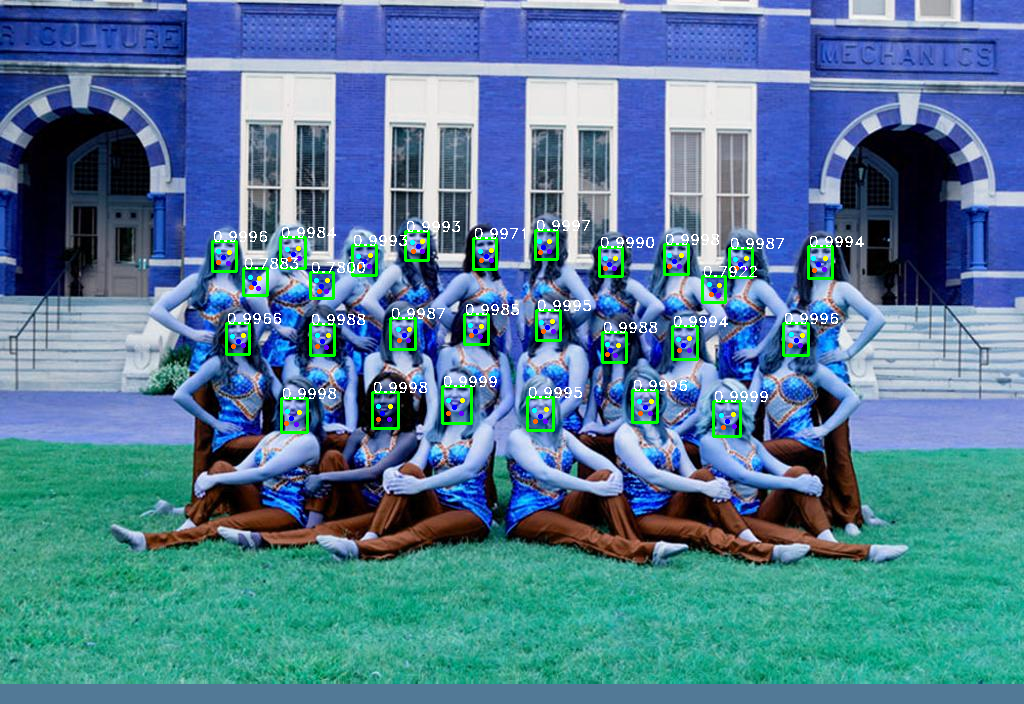

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(img)

In [ ]:
 tf.saved_model.save(model, './frozen_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./frozen_model/assets


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter = True
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmps34rjpyb/assets


In [ ]:
!pip install tensorflow-gpu==2.1

     |████████████████████████████████| 421.8MB 28kB/s 
     |████████████████████████████████| 3.9MB 38.2MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
     |████████████████████████████████| 450kB 40.0MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=d85124e211af3ba6215074372e0a1a66e984e349a64354015ede96cd2a536e43
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.3.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorflow-estimator<2.4.0,>=2.3.0, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing ins

In [ ]:
import tensorflow
tensorflow.__version__

'2.1.0'

In [ ]:
!tflite_convert --output_file=./model_graph_try.tflite --graph_def_file=/content/retinaface-tf2/frozen_model/saved_model.pb --saved_model_dir=/content/retinaface-tf2/frozen_model

2020-08-17 10:21:20.914029: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-08-17 10:21:20.917322: E tensorflow/stream_executor/cuda/cuda_driver.cc:351] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-08-17 10:21:20.917369: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bd52508dc69d): /proc/driver/nvidia/version does not exist
2020-08-17 10:21:21.007318: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200000000 Hz
2020-08-17 10:21:21.007718: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x563c43512a80 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-08-17 10:21:21.007763: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
Traceback (most recent call last):
  File "/usr/local/bin